# Explore 2016-2019 indicators

In [1]:
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load indicators
indicators = pd.read_csv('../data/PRAMS/csv/PRAMS_2016_2019.csv')

# Reformat state names 
for state in indicators['State'].unique():
    new_name = state[0]
    for ii in state[1:]:
        if ii.isupper():
            new_name += ' '
        new_name += ii
    indicators.loc[indicators['State'] == state, 'State'] = new_name
indicators.loc[indicators['State'] == 'New York State', 'State'] = 'New York'

In [3]:
# Load geography
states = geopandas.read_file('../data/cb_2020_us_state_500k/cb_2020_us_state_500k.shp')

# Remove extras (removed Alaska and Hawaii just for plotting)
extra = ['American Samoa', 'Commonwealth of the Northern Mariana Islands', 'Puerto Rico',
         'United States Virgin Islands', 'Guam', 'Alaska', 'Hawaii']
states = states[states['NAME'].isin(extra) == False]

In [4]:
# Merge data sets
df = states.copy()
df = df.merge(
    indicators,
    how='left',
    left_on='NAME',
    right_on='State'
)

In [5]:
# Which year has the most data?
for year in np.arange(2016, 2020):
    count = 48
    for state in df['State'].unique():
        if isinstance(state, str):
            temp = df[(df['Year'] == year) &
                      (df['State'] == state) &
                      (df['Category'] == 'Nutrition')]
            if len(temp) == 0:
                count -= 1
    print(f"Year: {year}, Count: {count}")

Year: 2016, Count: 34
Year: 2017, Count: 39
Year: 2018, Count: 45
Year: 2019, Count: 44


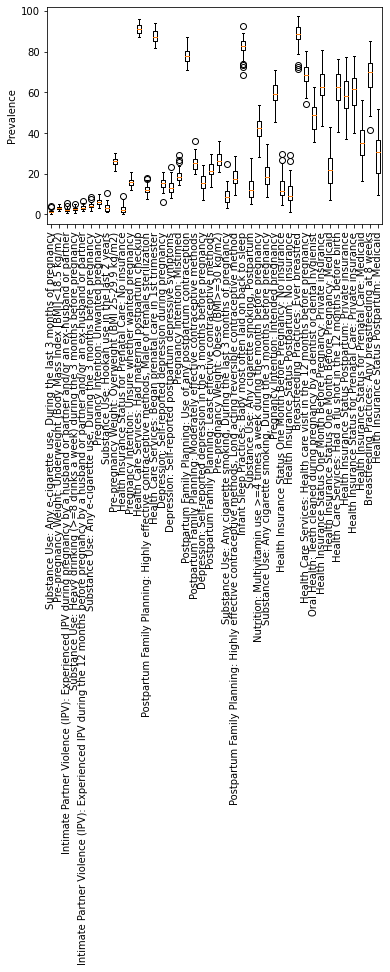

In [6]:
# In 2018, which indicators have the most variance?
stdev = []
values = []
labels = []
for category in df['Category'].unique():
    if isinstance(category, str):
        df_cat = df[df['Category'] == category]
        for indicator in df_cat['Indicator'].unique():
            df_ind = df_cat[df_cat['Indicator'] == indicator]
            for sub_indicator in df_ind['SubIndicator'].unique():
                if isinstance(sub_indicator, str):
                    df_sub = df_ind[df_ind['SubIndicator'] == sub_indicator]
                    title = category + ': ' + indicator + ', ' + sub_indicator
                else:
                    df_sub = df_ind
                    title = category + ': ' + indicator
                df_year = df_sub[df_sub['Year'] == 2018]
                stdev.append(df_year['Prevalence'].std())
                values.append(df_year['Prevalence'].tolist())
                labels.append(title)
idx = np.argsort(stdev)
plt.boxplot([values[ii] for ii in idx])
plt.xticks(ticks=np.arange(1, len(values) + 1), labels=[labels[ii] for ii in idx], rotation=90)
plt.ylabel('Prevalence');

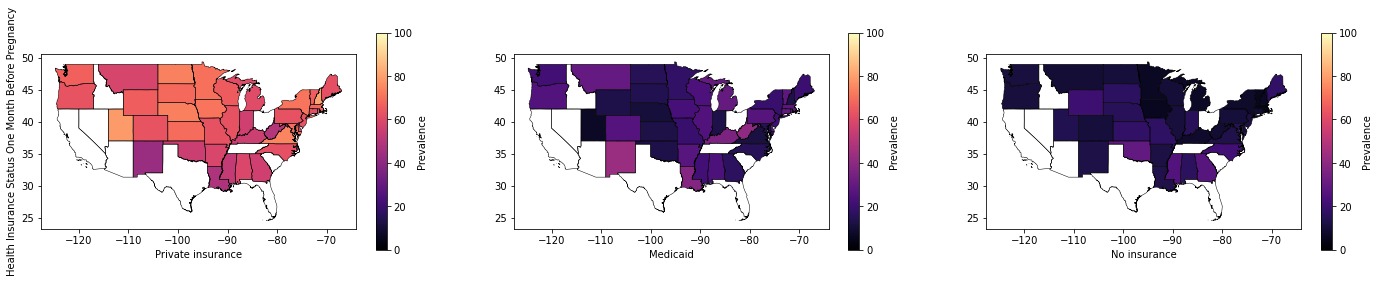

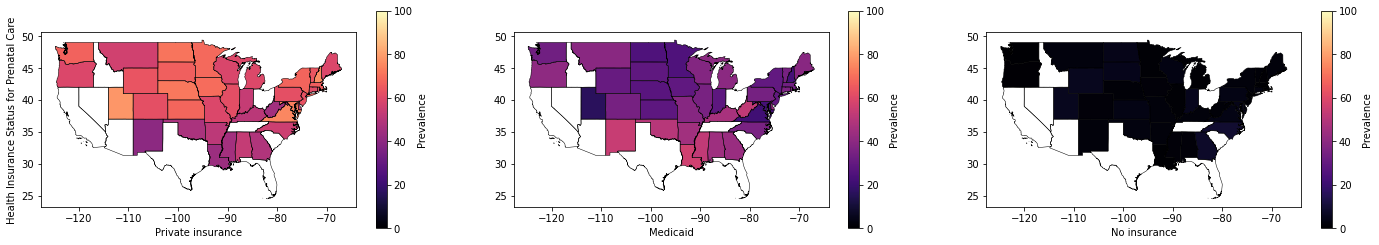

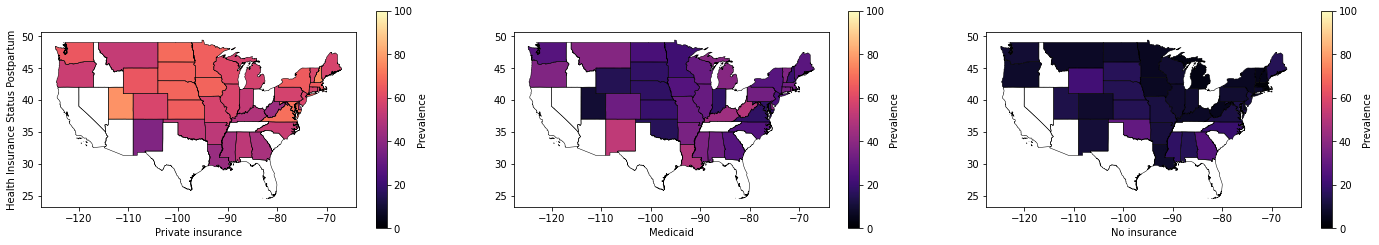

In [7]:
# How does insurance vary by location?
for category in df['Category'].unique():
    if isinstance(category, str) and 'Insurance' in category:
        df_cat = df[df['Category'] == category]
        fig, ax = plt.subplots(1, 3, figsize=(24, 4))
        for ii, indicator in enumerate(df_cat['Indicator'].unique()):
            df_ind = df_cat[df_cat['Indicator'] == indicator]
            title = category + ': ' + indicator
            states.boundary.plot(edgecolor='k', linewidth=0.5, ax=ax[ii])
            df_year = df_ind[df_ind['Year'] == 2018]
            df_year.plot(cmap='magma', vmin=0, vmax=100, column='Prevalence', legend=True,
                         legend_kwds={'label': 'Prevalence'}, ax=ax[ii])
            ax[ii].set_xlabel(indicator)
        ax[0].set_ylabel(category)

In [8]:
# Are these indicators correlated with births, infant deaths, infant death rates, or maternal mortality?
# Does the correlation vary by state?